<h1>CS166: Traffic Simulation Assignment</h1>

In this assignment, we use cellular automata to model traffic flow and explore the differences in traffic flow under varying traffic densities, number of lanes, and other conditions.  The traffic models to be examined are:

1) Single-lane Traffic Model

2) Two-Lane Traffic Model

3) Single-lane Extended Traffic Model

4) Two-Lane Extended Traffic Model

<h3>Base Model Features:</h3>

- Lanes
    - Numpy arrays with periodic boundary conditions.
- Cars 
    - Integers >= 0 in the array. 
    - 0 represents a stationary car.
    - Higher-value integers represent higher velocities up till the max velocity or current speed limit.
- Empty space(s) on the road, i.e. the distance between cars 
    - -1 integers in the array.

<h3>Assumptions and Limitations</h3>

All traffic models are uni-directional, have variable speeds, and operate within discrete time-steps. The driver behaviors are limited to the rules set in place for the respective models, and it is assumed that drivers do not act outside of the defined rule set.

<h2>Part 1: Traffic Jams on a Circular Road</h2>
<h3>Nagel-Schreckenberg Single-Lane Traffic Simulation Model</h3>

In the single-lane model, the following actions are conducted in order each time-step:

<b>1) Acceleration</b>

If the car's current velocity is not at the maximum velocity, increase its velocity by 1.

<b>2) Deceleration</b>

If the available front distance (number of empty cells between current car and the immediate car in front) is smaller than the car's current velocity, decrease its velocity to the value of the available front distance to avoid a collision. 

<b>3) Randomization</b>

The speed of all cars that have a velocity greater than or equal to 1 are reduced by one unit with probability slow_down_prob.

<b>4) Car motion</b>

All cars in the lane are moved forward the number of cells equal to their velocity.

In the simulation below, the model is run 100 times with 100 time-steps per run to analyze the average model behavior over 100 runs.

<h3>Building the Model</h3>

In [704]:
#import libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
sns.set()
%matplotlib inline

In [608]:
#Traffic Simulation base class
class TrafficSim:

    def __init__(self, length=100, no_of_lanes=1, car_density=0.3, slow_down_prob=0.5, max_speed=5, demo = False):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the lane. 
                Default: 100.
            
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 1.

            car_density (float) The fraction of cells that have a car on them.
                Default: 0.3.

            slow_down_prob (float) The probability that a car will randomly
                slow down by 1 during an update step. 
                Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
                Default: 5.
              
            demo (bool) If True, will display the lane along with all the cars on it.
                Default: False
        '''
        self.demo = demo
        self.length = length
        self.car_density = car_density
        self.no_of_lanes = no_of_lanes
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob

        # Track the time steps and total number of cars that passed the simulation
        # boundary to estimate average traffic flow.
        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        #set state by creating the lane(s)
        self.state = self.create_lane()
            
    
    def create_lane(self):
        '''
        Initializes lane according to road length, car density, and number of lanes.
        '''
            
        #choose random indexes to place the cars
        random_indexes = np.random.choice(range(self.length*self.no_of_lanes),                   
                                                size=int(round(self.car_density * self.length * self.no_of_lanes)),                
                                                replace=False)
        
        # -1 means empty cell
        state = -np.ones(self.length*self.no_of_lanes, dtype=int)  
        
        #place cars with random velocities along the lane
        state[random_indexes] = np.random.randint(0, self.max_speed + 1, 
                                                      size=len(random_indexes))
    
        return np.split(state, self.no_of_lanes) 
    
        
    def get_distances(self, curr_lane, index):
        '''
        Get the front and back distances of the given car.
        Distance is the number of empty cells between current car and next car plus 1.
        
        Inputs: 
        
            curr_lane: The current road that the car is on (numpy array)
            index: The index of the current car.
            
        Outputs: 
            
            front_dist: The available front distance of the current car.
            back_dist: The available back distance of the current car.
            
        '''
        
        front_dist, back_dist = 1,1

        while curr_lane[(index + front_dist) % len(curr_lane)] == -1:
            front_dist += 1
            if front_dist >= 6: break
        while curr_lane[(index - back_dist) % len(curr_lane)] == -1:
            back_dist += 1
            if back_dist >= 6: break
                
        return front_dist, back_dist  
    
    def update_cars(self):
        '''
        Update car velocities.
        
        For single-lane model, the following steps are implemented:
        
        - acceleration
        - deceleration
        - random slow-down
        '''
        #loop through all the cars in the lane
        for i in range(self.length):
            
            #if the index is a car
            if self.state[0][i] != -1: 
                
                #get the front and back distances of the current car
                f_dist, b_dist = self.get_distances(self.state[0],i)
                
                #Acceleration
                if self.state[0][i] + 1 < f_dist:
                    self.state[0][i] = min(self.state[0][i] + 1, self.max_speed)
                
                #Deceleration
                else: self.state[0][i] = max(f_dist - 1, 0)
                
                #Randomization
                if (self.state[0][i] > 0) and (np.random.uniform() < self.slow_down_prob):
                    self.state[0][i] -= 1
        
    def move_cars(self):
        
        '''
        Move cars according to their updated velocities.
        '''
        
        # initialize new empty state according to length and number of lanes
        new_state = np.split(-np.ones(self.length*self.no_of_lanes, dtype=int), self.no_of_lanes)
        
        #loop through updated velocities from the old lane
        #and move cars to new positions in the new lane
        for lane in range(self.no_of_lanes):
            for i in range(self.length):
                if self.state[lane][i] != -1:
                    new_state[lane][(i + self.state[lane][i]) % self.length] = self.state[lane][i]
                    
        return new_state  

    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #update car velocities
        self.update_cars()

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #Move cars 
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

    def get_traffic_flow(self):
        '''
        Traffic flow is calculated as the number of cars that pass the periodic boundary per time step.
        This function updates the time step by 1, and updates the number of cars that have passed 
        the periodic boundary at a given time step.
        '''
        #update time-step
        self.time_step += 1
        
        #update traffic flow
        for lane in range(len(self.state)):
            for i in range(self.max_speed):
                if self.state[lane][i] > i:
                    self.cumulative_traffic_flow += 1
                    
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for lane in range(self.no_of_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.state[lane]))
        print()
        

In [811]:
def sim_demo(title, traffic_sim, **kwargs):
    '''
    Demo of traffic sim moving 5 time-steps.
    '''
    #initialize sim
    sim = traffic_sim(demo=True, **kwargs)

    print(title+'\n')
    
    #observe next 10 time-steps
    for i in range(5):
        sim.step()

demo_densities = [0.1,0.5,0.9]

for d in demo_densities:
    sim_demo(f'Single-lane Traffic Model, {d} car density', TrafficSim, car_density = d)

Single-lane Traffic Model, 0.1 car density

..........1.0.........................3...0...............1.01...........1...........3...4..........

...........00............................01................01.2...........1.............3....5......

...........00............................0.1...............1.2..2..........2...............3......5.

...4.......00............................0..1...............1..1..3..........2................4.....

.......3...00............................1...1...............1..1....4.........2..................4.

Single-lane Traffic Model, 0.5 car density

....03....0000.....01..1..01.00000001..0.2...1..1....0005.....0.0.2..01.2..1.0.001.0.01.001.02..0003

..0.0...0.0001.....0.1..0.0.00000000.1.1...1..1..2...000.....00.0...01.1..1.00.01.01.1.001.01..0001.

..0.0...0.000.2....0..1.1.0.00000001..0.1...2..2...0.000.....01.1...1.1.2..001.0.01.1.000.01.1.000.2

.00.0...0.001...2..1...1.01.0000000.1.1..1....1..0.1.000.....1.1.2...1.2..001.01.0.1.0000.0.1.00

<h3>Running Simulations</h3>

In [766]:
#set the default density outside for convenient adjusting
density=np.arange(0,1.05,0.05)

def sim_diff_density(traffic_sim, density=density, n_loops=100, **kwargs):
    
    '''
    Run traffic simulation at different densities to analyze traffic behavior.
    For each loop in n_loops, the simulation is updated by 100 steps.
    
    Inputs:
        
    traffic_sim (class) The traffic simulation class to be used.
                
    density (arr) The range of traffic densities to test for.
        Default: np.arange(0,1.05,0.05)

    n_loops (int) The number of times to run the simulation.
        Default: 100
        
    **kwargs Any additional keywords for the traffic_sim class
        
    Outputs:
    
    avg_traffic_flows (lst) Traffic flows for each density (length: n_loops)
    
    mean_traffic_flows (lst) Mean traffic flows for each density (length: len(density))
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
                            (length: len(density))
    
    '''
    avg_traffic_flows = []
    mean_traffic_flows = []
    CI_traffic_flows = []

    for d in density:

        temp = []

        for n in range(n_loops):
            #initialize the sim with a given density
            sim = traffic_sim(car_density=d, **kwargs)
            
            #update the sim 100 times
            for t in range(100):
                sim.step()

            #get the traffic flow for a given density
            avg_traffic_flows.append((d, sim.cumulative_traffic_flow / sim.time_step))
            temp.append(sim.cumulative_traffic_flow / sim.time_step)

        #mean traffic flow for a given density
        mean_traffic_flows.append(np.mean(temp))
        
        #95 CI of traffic flow for a given density
        CI_traffic_flows.append(np.percentile(temp,[2.5,97.5]))
        
    return avg_traffic_flows, mean_traffic_flows, CI_traffic_flows
    
def plot_flow(avg_traffic_flows, mean_traffic_flows, CI_traffic_flows, title='', density=density):
    '''
    Plots the traffic flows, mean and 95% CI across different densities.
    x-axis: range of densities
    y-axis: traffic flow value
        
    Inputs:
    
    avg_traffic_flows (lst) Traffic flows for each density
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    density (arr) The different levels of traffic density.
        Default: np.arange(0,1.05,0.05)
    
    '''
    traffic_flows = np.array(avg_traffic_flows)
    
    plt.scatter(traffic_flows[:,0],traffic_flows[:,1], alpha = 0.5, c="orange")
    plt.plot(density, mean_traffic_flows)
    plt.plot(density, np.array(CI_traffic_flows)[:,0], ls='dashed')
    plt.plot(density, np.array(CI_traffic_flows)[:,1], ls='dashed')
    
    plt.title(f"Plot of Traffic Density vs Traffic Flow ({title})",size=15)
    plt.xlabel("Traffic Density",size=15)
    plt.ylabel("Traffic flow",size=15)
    

In [719]:
#run simulation and store generated output in variables
single_lane_traffic_flows, single_lane_mean, single_lane_CI = sim_diff_density(TrafficSim) 


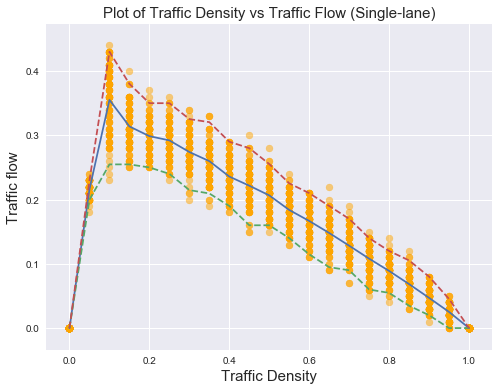

,Traffic Density,Single-lane Mean flow,95 CI
0,0.0,0.0000,"[0.0, 0.0]"
1,0.1,0.3551,"[0.25475000000000003, 0.43]"
2,0.2,0.2987,"[0.25, 0.35]"
3,0.3,0.2740,"[0.21475, 0.32524999999999993]"
4,0.4,0.2358,"[0.19, 0.29]"
5,0.5,0.2065,"[0.16, 0.2552499999999999]"
6,0.6,0.1667,"[0.11474999999999999, 0.21]"
7,0.7,0.1282,"[0.09, 0.17]"
8,0.8,0.0889,"[0.05475, 0.12]"
9,0.9,0.0470,"[0.02, 0.08]"


In [770]:
#plot stats
plt.figure(figsize=(8,6))
plot_flow(single_lane_traffic_flows, single_lane_mean, single_lane_CI, 'Single-lane')
plt.show()

#create dataframe
single_lane_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': single_lane_mean[::2],
    '95 CI': single_lane_CI[::2]
    })

single_lane_df

<h2>Part 2: Multi-lane Highways</h2>
<h3>Two-lane Traffic Simulation Model</h3>

The two-lane model builds off the single-lane parent class. The most prominent addition in the two-lane model is that cars are now able to switch lanes if they are unable to accelerate in their current lane. This is under the condition that there is sufficient front and back distance in the other lane for the car to safely switch without risk of collision. 

Note that the car_density parameter in the two-lane model refers to the car_density in the *entire system*, not just for a single lane. For example, a car_density = 0.5 would mean 50 cars in the original 100-cell lane model, but since the two-lane model has a total length of 200 cells, a car_density of 0.5 would produce 100 cars in the whole system, distributed in random ratios between the two lanes.

The new rule-set is as follows:

<b>1) Acceleration in current lane</b>

Similar to the single-lane model, the car first checks if there is available front distance to accelerate in their current lane. 

<b>2) Check if lane-switch is possible</b>

Iff there isn't available front distance in the current lane:
   - check if there is available front distance in the other lane to accelerate.
   - check if there is available back distance in the other lane (back distance < max speed to ensure that a collision is impossible no matter the back car's location or current velocity).
   
<b>3) Switch lanes with probability switch_lane_prob</b>

If the above conditions are met, switch lane with probability switch_lane_prob.

<b>4) Randomization</b>

The speed of all cars that have a velocity greater than or equal to 1 are reduced by one unit with probability slow_down_prob.

<b>4) Car motion</b>

All cars in the lane(s) are moved forward the number of cells equal to their velocity.


<h3>Building the Model</h3>

In [721]:
class TrafficSimTwoLane(TrafficSim):

    def __init__(self, length=100, no_of_lanes = 2, car_density=0.3, slow_down_prob=0.5, switch_lane_prob=1, max_speed=5, demo = False):
        
        '''
        TrafficSimTwoLane inherits from the TrafficSim parent class.
        The no_of_lanes is now defaulted at 2.
        A new variable, switch_lane_prob, is introduced.

        Inputs:
        
            no_of_lanes (int) The number of lanes in the simulation. 
                                Default: 2.
                
            switch_lane_prob (int) The probability of a car switching lanes, 
                                   given that a lane switch is possible. 
                                    Default: 1.

        '''
        
        #inherit from parent TrafficSim class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, max_speed, demo)
        
        #initialize switch_lane_prob
        self.switch_lane_prob = switch_lane_prob
    
    def update_cars(self,old_state,curr_lane,other_lane):
        '''
        Update car velocities with/without lane switch.
        
        For two-lane model, the following steps are implemented:
        
        - acceleration
        - lane-switch
        - random slow down
        
        Inputs:
        
            old_state (arr) A deep copy of the last updated state as reference when
                            updating both lanes
                
            curr_lane (int) The index of the current lane that the car is on.
                                    
            other_lane (int) The index of the other lane that the car can switch to.
        '''
        #loop through the lane
        for i in range(self.length):
            
            #if the index is a car
            if old_state[curr_lane][i] != -1: 
                
                #get front and back distance of current lane
                f_dist, b_dist = self.get_distances(old_state[curr_lane], i)
                
                #get front and back distance of other lane
                fo_dist, bo_dist = self.get_distances(old_state[other_lane], i)
                    
                #Try accelerating in current lane
                if old_state[curr_lane][i] + 1 < f_dist:
                    self.state[curr_lane][i] = min(old_state[curr_lane][i] + 1, self.max_speed)
                
                else: #if acceleration is not possible, try switching lanes:

                    #if switching lanes is possible, switch lane with probability switch_lane_prob.
                    if old_state[other_lane][i] == -1 and old_state[curr_lane][i] + 1 < fo_dist and bo_dist > self.max_speed:
                        
                        if np.random.uniform() < self.switch_lane_prob:
                            
                            #switch to the other lane
                            self.state[other_lane][i] = min(old_state[curr_lane][i] + 1, self.max_speed)
                            #assign empty spot where the car used to be
                            self.state[curr_lane][i] = -1

                    #if switching lanes is not possible, decelerate in current lane
                    else: self.state[curr_lane][i] = max(f_dist - 1, 0)
     

                # Random slow down
                if (self.state[curr_lane][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                    self.state[curr_lane][i] -= 1

        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities and/or switch lanes
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

                

In [737]:
#demo of two-lane traffic simulation
for d in demo_densities:
    sim_demo(f'Two-lane Traffic Model, {d} car density', TrafficSimTwoLane, no_of_lanes = 2, car_density = d)
    
    

Two-lane Traffic Model, 0.1 car density

.............3..............3..................2..................44.........2......4..........5....
.........2...........5..............3.............3....4............2......0.02........1....2...5...

5...............4..............3.................3....................05.......2........4...........
.5.........2..............5............3.............4.....5..........3....1.1..2.......2.....2.....

.....5..............5.............4.................4.................1.....3....3..........4.......
......5......2.................4..........3..............5......4........2..1.2...3.......3.....2...

..........5..............5............4.................5..............1.......3....4...........5...
...........3...3...................5.........3................5.....4......1.2..3....4.......4....3.

.4.............4..............4...........4..................5..........1.........3.....4...........
.4............2...3.....................4.....

<h3>Running Simulations</h3>

In [738]:
#generate two-lane traffic flow stats using switch_lane_prob of 0, 0.5, and 1.
two_lane_traffic_flows_0, two_lane_mean_0, two_lane_CI_0 = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=0)
two_lane_traffic_flows_05, two_lane_mean_05, two_lane_CI_05 = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=0.5)
two_lane_traffic_flows_1, two_lane_mean_1, two_lane_CI_1 = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=1)


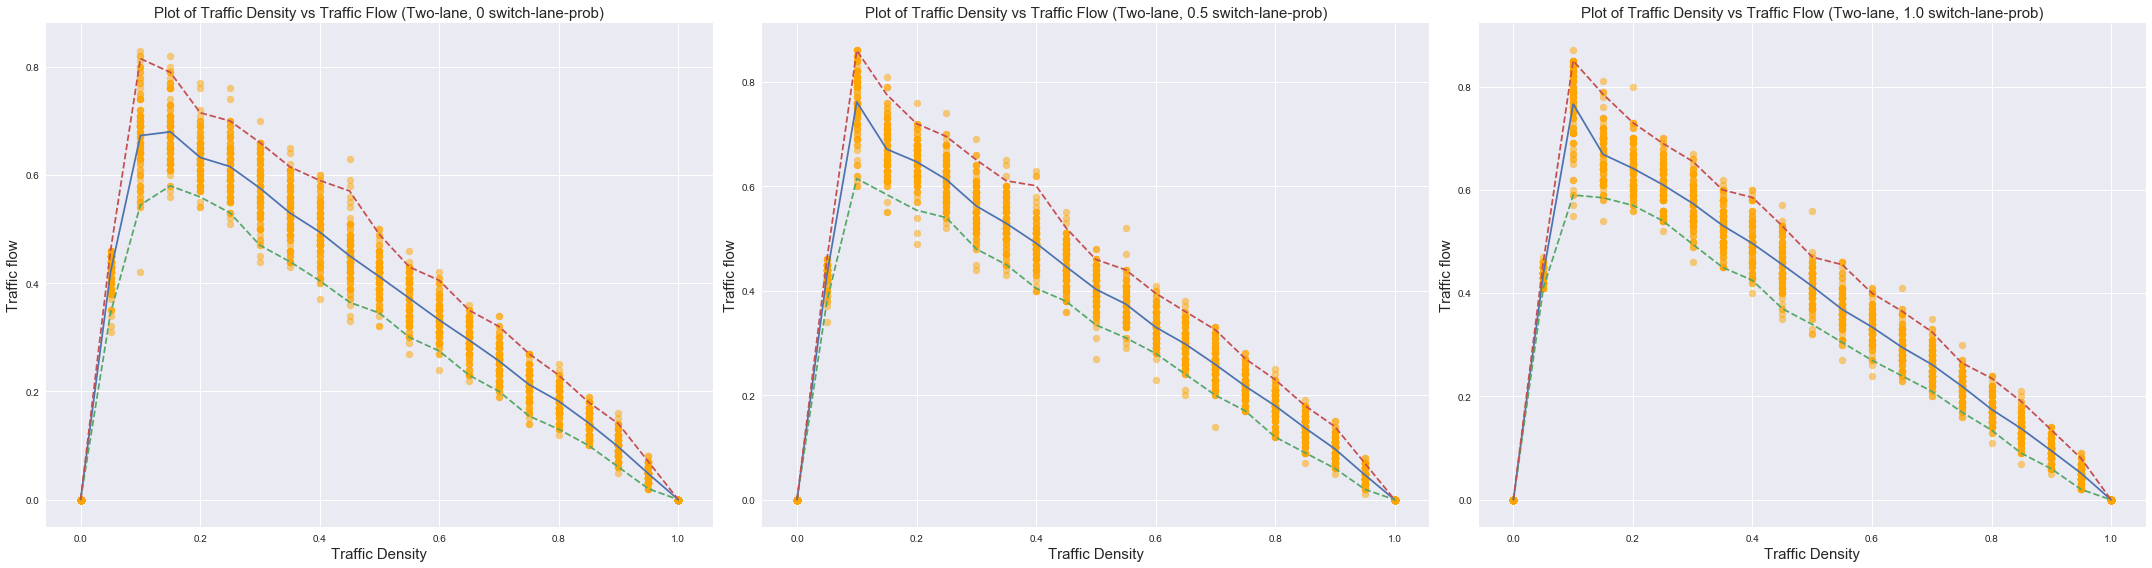

In [772]:
#plot stats
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plot_flow(two_lane_traffic_flows_0, two_lane_mean_0, two_lane_CI_0, f'Two-lane, 0 switch-lane-prob')
plt.subplot(1,3,2)
plot_flow(two_lane_traffic_flows_05, two_lane_mean_05, two_lane_CI_05, f'Two-lane, 0.5 switch-lane-prob')
plt.subplot(1,3,3)
plot_flow(two_lane_traffic_flows_1, two_lane_mean_1, two_lane_CI_1, f'Two-lane, 1.0 switch-lane-prob')
plt.tight_layout()

In [781]:
#create dataframe for two-lane model
two_lane_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Two-Lane (0 switch_lane_prob) Mean flow': two_lane_mean_0[::2],
    'Two-Lane (0.5 switch_lane_prob) Mean flow': two_lane_mean_05[::2],
    'Two-Lane (1.0 switch_lane_prob) Mean flow': two_lane_mean_1[::2]
    })

#merge single-lane and two-lane dfs together
traffic_flow_df = pd.merge(single_lane_df[['Traffic Density','Single-lane Mean flow']],two_lane_df)

traffic_flow_df

,Traffic Density,Single-lane Mean flow,Two-Lane (0 switch_lane_prob) Mean flow,Two-Lane (0.5 switch_lane_prob) Mean flow,Two-Lane (1.0 switch_lane_prob) Mean flow
0,0.0,0.0000,0.0000,0.0000,0.0000
1,0.1,0.3551,0.6730,0.7614,0.7662
2,0.2,0.2987,0.6326,0.6470,0.6416
3,0.3,0.2740,0.5758,0.5622,0.5738
4,0.4,0.2358,0.4947,0.4912,0.4963
5,0.5,0.2065,0.4120,0.4030,0.4134
6,0.6,0.1667,0.3321,0.3304,0.3345
7,0.7,0.1282,0.2563,0.2589,0.2620
8,0.8,0.0889,0.1818,0.1799,0.1751
9,0.9,0.0470,0.0972,0.0973,0.0950


In [798]:
def get_max_vals(df, col_name):

    max_mean_flow = round(df[col_name+' Mean flow'].max(),4)
    max_flow_density = df[df[col_name+' Mean flow']==df[col_name+' Mean flow'].max()]['Traffic Density'][1]

    print(f"{col_name}: Max mean flow is {max_mean_flow} at traffic density {max_flow_density}")

get_max_vals(traffic_flow_df, 'Single-lane')
get_max_vals(traffic_flow_df, 'Two-Lane (0 switch_lane_prob)')
get_max_vals(traffic_flow_df, 'Two-Lane (0.5 switch_lane_prob)')
get_max_vals(traffic_flow_df, 'Two-Lane (1.0 switch_lane_prob)')

Single-lane: Max mean flow is 0.3551 at traffic density 0.1
Two-Lane (0 switch_lane_prob): Max mean flow is 0.673 at traffic density 0.1
Two-Lane (0.5 switch_lane_prob): Max mean flow is 0.7614 at traffic density 0.1
Two-Lane (1.0 switch_lane_prob): Max mean flow is 0.7662 at traffic density 0.1


<h2>How the Models Works</h2>

<h3>Single-lane Model</h3>

<b>Step 1: Creating the Road</b>

First, the model is initialized by creating a numpy array of length 100. This is the specified road length, and can be adjusted as needed. Each cell in the numpy array represents a unit of distance in the road - if the cell is empty, it represent the distance between cars; if the cell is filled, the filled value represents the current velocity of a car.

Random indexes are selected from the numpy array, and filled with random car velocities as according to the specified car density. 

<b>Step 2: Updating Car Velocities</b>

After the lane and cars have been initialized, the updating can begin. At each time-step, we loop through the lane(s) in the model to update each car index according to a set of rules: acceleration, deceleration, and randomization. In acceleration, we check that there is enough front distance for the car to move forward the number of steps equal to its current velocity. If the front distance is greater than the current car velocity + 1, we allow the car to increase its velocity by 1 (up to the max velocity ceiling) since it can do so without colliding into the car in front. If the front distance is smaller than or equal to the car velocity + 1, then the car has to either decelerate or maintain its current velocity so that at most, it only reaches the cell immediately behind the car in front in the next time-step. The lowest possible velocity is 0, which symbolizes a stationary car.

<b>Step 3: Random Slow Down</b>

The random slow down step is needed in order to simulate traffic jam behavior. Without a randomized slow down, the cars will keep driving at a stable speed at an adjusted distance from each other that maintains a steady flow. Theoretically if people in real life drove like this, there would be no traffic jams in real life either. Unfortuantely, that is never the case. When a driver randomly slows down, their behavior becomes unpredictable, and so a stable traffic flow cannot be achieved. The random slow down is initiated by generating a random number bewteen 0 and 1 from the np.random.uniform function and comparing it against the slow_down_prob. If the number is less than the slow_down_prob, then the car decreases its velocity by 1 unit.

<h3>Two-lane Model</h3>

The two-lane model builds off the single-lane model by introducing the option of switching lanes. The switch-lane step occurs right after the acceleration step. If the car can accelerate in its current lane, it will do so and will not switch lanes. If the car cannot accelerate in its current lane, it will check the other lane to see if it can switch lanes. If the car can safely switch lanes, it will switch to the other lane. If it cannot safely switch lanes, it will decelerate in the current lane.

<b>Conditions needed to safely switch lanes:</b>

- the front distance in the other lane should be greater than the car's current velocity + 1 so that the car can accelerate in the other lane, in a way that it could not in its own lane.


- the back distance in the other lane should be greater than the max velocity of the cars to ensure that it is *impossible* for a car behind to hit into the current car. Even if a car in the other lane is 4 cells behind us and has a speed of 1, we still will not switch lanes since the available back distance is only 4, while the general max velocity of all cars in this model is 5. The back distance has to be greater than 5 for the current car to safely switch lanes.


<h2>Summary of Key Results</h2>

<h3>Question 1</h3>

How much more traffic can flow through a 2-lane road compared to a 1-lane road at the
same traffic density? What about roads with more than 2 lanes? Either model 3 or more
lanes and report on your results, or predict how much larger the traffic flow through a 3+
lane road will be compared to a 1-lane road at the same traffic density.

<h4>Two-lane Model vs Single-lane Model</h4>

From the graph and tables generated above, we see that for each model, the highest mean traffic flow occurs at a density of 0.1. For the single-lane model of 100 cells, this means that maximum flow occurs when there are 10 cars in the system. For the two-lane model of a total of 200 cells, the maximum flow occurs when there are 20 cars in the system.

Since the two-lane model is double the size of the single-lane model, if the two-lane model is at least as efficient as the single-lane model, then given a fixed density, the two-lane flow should be double the single-lane flow. If the two-lane model is less efficient, then the two-lane flow should be less than double the single-lane flow; if the two-lane model is more efficient, the two-lane flow should be more than double the single-lane flow.

The results show that at a density of 0.1 (the optimal density for both the single-lane and two-lane models), and a switch_lane_prob of 0, the two-lane model actually underperforms the single-lane model by a relative measurement of $(2 \times 0.3551) - 0.673 = 0.0372$ units. - this is probably due to the uneven distribution of the 0.1 car_density throughout the entire two-lane system, i.e. 1 road could have 5 cars while the other has 15, which overall would lead to suboptimal performance compared to the optimal 10 cars per 100 cells as achieved by the single-lane model. Since the switch_lane_prob is 0, the cars cannot switch lanes to create an "optimized" ratio that could lead to better flow.

At the same traffic density of 0.1, the 0.5 and 1.0 switch_lane_prob two-lane models both outperform the single-lane model, i.e. they have traffic flows that are more than double the single-lane flow. The relative measurements of improvement are $0.7614 - (2 \times 0.3551)= 0.051$ units for the 0.5 switch_lane_prob model, and $0.7662 - (2 \times 0.3551)= 0.056$ for the 1.0 switch_lane_prob model. This suggests that if there is a high probability of cars switching lanes given that they can safely do so, then the traffic flow performance will increase at the optimal system density of 0.1.

It should be noted that this improved traffic flow performance appears to *only occur at the optimal system density of 0.1*, and even then, the improvement is small - only ~0.05 units of increased traffic flow. At traffic densities greater or less than 0.1, the difference in traffic flow between the two-lane traffic models and the single-lane model decreases. Both these observations suggest that overall, the two-lane model does not significantly improve traffic-flow performance, even at a switch_lane_prob of 1. 

<h4>Prediction of Three-lane Model Performance</h4>

The lacklustre increase in traffic-flow of the two-lane model at a switch_lane_prob of 1 vs the single-lane model, even at an optimal traffic density of 0.1, suggests that a three-lane model would not perform that much better. There will probably be a small increase in traffic-flow around the optimal density point of 0.1 - when cars can safely switch lanes without interrupting the traffic-flow of the other lanes - but at densities greater or less than 0.1, the three-lane model traffic-flow will probably only be roughly 3 times the single-lane model's traffic-flow, which means that there isn't a significant improvement besides the expected improvement of having a system that is 3 times the size of the original one. 

<h3>Question 2</h3>

How applicable is this model to traffic in your current city? Write a short paragraph and motivate
why the model is suited to traffic in your city (or why it is not).

<h4>Applicability of Traffic Model to Buenos Aires</h4>

As it is, the model is too bare-bones to be applicable to Buenos Aires traffic. The fact that the model only consists of a single, straight road, without any traffic lights or intersections, means that it could only be applicable to a very simple traffic environment, perhaps in the country-side or in a small town. Buenos Aires is a busy city with one of the widest roads in the world (<a href='https://en.wikipedia.org/wiki/9_de_Julio_Avenue'>9 de Julio Avenue</a>), and I don't believe that the complexity of it's traffic flow could be accurately captured in such a reduced form.

I do not think that the model can even capture the behavior of small, single lanes in Buenos Aires since these lanes always end up opening onto a main road, and are also not long enough to be considered a self-contained system.

While I do not know too much about the driving rules and regulations in Buenos Aires, the model does seem to capture general driving behavior rather accurately, and I have not personally witnessed any behavior in Buenos Aires that goes against normal driving behavior. With the addition of more lanes and other features (traffic lights, zebra-crossings, random pedestrians crossing the road, obstacles, etc.), perhaps the model could be applicable to Buenos Aires traffic.

<h2>Part 3: Extended Single-lane Model</h2>

The extended single-lane model builds on the TrafficSim parent class. Using the extended model, we can investigate the effects of obstacles, speed-limit zones, and traffic lights on regular traffic flow.

<h3>Additional Features of Extended Model:</h3>

- Obstacles
    - Permanent 0-valued stationary object set at a specific cell on the road.
- Speed-limit zones
    - Permanent maximum velocity set for specific sections of the road.
    - Different sections can have different maximum velocities.
- Traffic lights
    - Temporarily enforced 0-value max velocity at a specific cell in the road for regular intervals in the simulation.
    - The traffic light maintains the same green-light (go) interval and same red-light (stop) interval throughout the entire simulation, i.e. it does not change intervals according to the road status.

<h3>Building the Model</h3>

In [871]:
#the global time is the number of steps that the model will be updated in the simulation for each simulation loop.
global_time = 100

class TrafficSimExtended(TrafficSim):
    
    def __init__(self, length=100, no_of_lanes = 1, car_density=0.3, slow_down_prob=0.5, 
                 max_speed=5, speed_lim=[5,1,5], 
                 speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]), 
                 traffic_light = (0,50,3,2),
                 obstacle = (0,30),
                 demo = False):
        
        '''
        TrafficSimExtended inherits from the TrafficSim parent class.
        New variables: speed_lim, speed_lim_zone, traffic_light, obstacle.
        
        Inputs:
                
            speed_lim (arr) The speed limits in the speed limit zone ranges.
                Default: [5,1,5]
                
            speed_lim_zone (tuple) The speed limit zone lane and ranges.
                Default: (0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)])
                
            traffic_light (arr) The traffic light lane, index, on-time, and off-time as a tuple.
                Default: (0,50,10,10) traffic light at lane 0, index 50, with 10 on-time and 10 off-time.
                
            obstacle (tuple) The lane and index of the obstacle.
                Default: (0,30) - First lane, index 30.

        '''
        
        #inherit from parent TrafficSim class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, max_speed, demo)
        
        #speed limit variables
        self.speed_lim = speed_lim
        self.speed_lim_zone = speed_lim_zone
        
        #traffic light variables
        self.traffic_light = traffic_light
        #create regular intervals for go-time and stop-time
        self.traffic_light_int = np.array(
                                    [np.arange(i, i + traffic_light[2]) 
                                    if (i+traffic_light[2])<global_time else np.arange(i,global_time) 
                                    for i in np.arange(global_time)[::(traffic_light[2]+traffic_light[3])]]
                                    ).flatten()
        
        #obstacle variables
        self.obstacle = obstacle
       
    def update_cars(self):

        for i in range(self.length):
            
            #set obstacle index to 0
            if i == self.obstacle[1]: self.state[0][i] = 0
            

            else: #if index is not obstacle, proceed as usual
                
                #if the index is a car
                if self.state[0][i] != -1: 
                    
                    #set current max speed according to traffic light and speed-limit-zone checks
                    curr_max_speed = min(self.check_speed_limit(0,i),self.check_traffic_light(0,i))

                    #get the front and back distances of the current car
                    f_dist, b_dist = self.get_distances(self.state[0],i)

                    #Acceleration
                    if self.state[0][i] + 1 < f_dist:
                        self.state[0][i] = min(self.state[0][i] + 1, curr_max_speed)

                    #Deceleration
                    else: self.state[0][i] = min(max(f_dist - 1, 0), curr_max_speed)
                        
                    #Randomization
                    if (self.state[0][i] > 0) and (np.random.uniform() < self.slow_down_prob):
                        self.state[0][i] -= 1
                    

    def check_speed_limit(self,lane,index):
        '''
        set the current max speed of the car according to speed limit zone restrictions
        '''
        if lane == self.speed_lim_zone[0]:
            for i in range(len(self.speed_lim_zone[1])):
                
                #check which speed limit zone the car is in
                if index in self.speed_lim_zone[1][i]:
                    
                    #assign the appropriate speed limit for that zone
                    return self.speed_lim[i]
                
        return self.max_speed
    
    def check_traffic_light(self,lane,index):
        '''
        Checks if:
        - traffic light is on,
        - car is on traffic light lane, and
        - car's current velocity + index >= traffic light index
        if all conditions are met, the car's max velocity is (traffic_light_index - car_index).
        
        Traffic light turns on at the first time-step, then turns off and on in regular intervals
        as specified in self.traffic_light_int
        '''
        #if traffic light is on
        if self.time_step in self.traffic_light_int:
            
            #if the current lane is the traffic light lane
            if lane == self.traffic_light[0]:
                
                #if the car is behind or at the traffic light
                if index <= self.traffic_light[1]:
                
                    #if the car's next step >= the traffic light index
                    if self.state[lane][index] + index >= self.traffic_light[1]:
                        return self.traffic_light[1] - index
                
        #if none of the above conditions are met, return regular max velocity
        return self.max_speed
        
    def display(self):
        '''
        Traffic light index is red when off, green when on.
        Obstacle index is blue.
        '''
        for lane in range(self.no_of_lanes):
            
            disp = ['.' if x == -1 else str(x) for x in self.state[lane]]
            
            #print obstacle blue
            if lane == self.obstacle[0]:
                disp[self.obstacle[1]] = f"\x1b[34m{disp[self.obstacle[1]]}\x1b[0m"
            
            #print traffic light red when it's on, green when it's off
            if lane == self.traffic_light[0]:
                if self.time_step in self.traffic_light_int:
                    disp[self.traffic_light[1]] = f"\x1b[31m{disp[self.traffic_light[1]]}\x1b[0m"
                else:
                    disp[self.traffic_light[1]] = f"\x1b[32m{disp[self.traffic_light[1]]}\x1b[0m"
            
            print(''.join(x for x in disp))
            
        print()
            


In [945]:
#demo of extended single-lane traffic simulation
#obstacle at index 30
#traffic light at index 50, on-time of 3, off-time of 2.
#speed limit of 1 in the range (34,67)

np.random.seed(34)
for d in demo_densities:
    sim_demo(f'Single-lane Extended Traffic Model, {d} car density', TrafficSimExtended, car_density = d)
    

Single-lane Extended Traffic Model, 0.1 car density

....1.....2...02..............0.2.................0..0.....1..............3................1........

.....2......0.0..3............0...0...............0..1......1................4..............1.......

.......2....1.1.....3.........0...1...............0...1......0...................4...........2......

.........3...0.2.......4......0....1..............0....1.....0.......................5.........2....

............01...3.........1..0.....1.............0.....0....0............................4......2..

Single-lane Extended Traffic Model, 0.5 car density

001.1.0.2...0.0001..1.2..0.00000.2..0.0..0..00....01..1..001..01..01.1..00001.2..0.1.0.3...01.03....

01.0.01...1.0.000.1..1..01.00001...01.0..0..01....0.0..1.01.1.1.1.0.0.0.0000.2..00..00....00.01...1.

0.00.1.2...01.001..2..0.0.00000.1..1.00..1..1.1...0.0...00.0.0.1.00.0.1.0000...001..00....01.0.2...0

1.01..1..1.0.001.2...00.1.00000..1..001...1..0.0..0.1...00.0.0..000.0..00000..

<h2>Part 4: Extended Two-lane Model</h2>

The extended two-lane model builds on the TrafficSimTwoLane parent class. Using the extended model, we can investigate the effects of obstacles, speed-limit zones, traffic lights, and lane-merges on regular traffic flow.

<h3>Additional Features of Extended Two-Lane Model:</h3>

The additional features are similar to the extended single-lane model, with the addition of a lane-merge feature:

- Lane merges (only for two-lane model)
    - Permanent 0-valued chain of stationary objects set along a series of cells on the road.


<h3>Building the Model</h3>

In [938]:
class TrafficSimExtendedTwoLane(TrafficSimExtended):
    
    def __init__(self, length=100, no_of_lanes = 2, car_density=0.3, 
                 slow_down_prob=0.5, switch_lane_prob = 1,
                 max_speed=5, speed_lim=[5,1,5], 
                 speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]), 
                 traffic_light = (0,50,3,2),
                 obstacle = (0,30),
                 lane_merge = (0,np.arange(70,100)),
                 demo = False):
        
        '''
        TrafficSimExtendedTwoLane inherits from the TrafficSimExtended parent class.
        The no_of_lanes is now defaulted at 2.
        New variables: switch_lane_prob, lane_merge.

        Inputs:
        
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 2.
                
            switch_lane_prob (int) The probability of a car switching lanes, 
                                    given that a lane switch is possible. 
                Default: 1.
                
            lane_merge (tuple) The lane and indices where lane-merge occurs.
                Default: (0, np.arange(75,100))

        '''
        
        #inherit from TrafficSimExtended class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, 
                         max_speed, speed_lim, speed_lim_zone, 
                         traffic_light, obstacle, demo)
        
        #initialize new variable, switch-lane_prob
        self.switch_lane_prob = switch_lane_prob
        
        #lane-merge variable
        self.lane_merge = lane_merge
       
    def update_cars(self,old_state,curr_lane,other_lane):

        for i in range(self.length):
            
            #obstacle check
            if curr_lane == self.obstacle[0] and i == self.obstacle[1]:
                old_state[curr_lane][i] = 0
                self.state[curr_lane][i] = 0
                
            #lane-merge check
            elif curr_lane == self.lane_merge[0] and i in self.lane_merge[1]:
                old_state[curr_lane][i] = 0
                self.state[curr_lane][i] = 0
            
            else: #if not obstacle, proceed as usual
                
                #if the index is a car
                if old_state[curr_lane][i] != -1: 

                    #set current max speed according to traffic light and speed-limit-zone checks
                    curr_max_speed = min(self.check_speed_limit(curr_lane,i),self.check_traffic_light(curr_lane,i))

                    #get front and back distance of current lane
                    f_dist, b_dist = self.get_distances(old_state[curr_lane], i)

                    #get front and back distance of other lane
                    fo_dist, bo_dist = self.get_distances(old_state[other_lane], i)

                    #Acceleration in current lane
                    if old_state[curr_lane][i] + 1 < f_dist:
                        self.state[curr_lane][i] = min(old_state[curr_lane][i] + 1, curr_max_speed)

                    else: #if acceleration is not possible, try switching lanes
                        
                        #check if there is no car occupying the other lane at the same index, and that there is sufficient front and back distance
                        if old_state[other_lane][i] == -1 and old_state[curr_lane][i] + 1 < fo_dist and bo_dist > self.max_speed:

                            #check what the max speed in the other lane would be based on speed limits and traffic lights
                            other_max_speed = min(self.check_speed_limit(other_lane,i),self.check_traffic_light(other_lane,i))
                            
                            #if the car can travel faster in the other lane
                            if other_max_speed > curr_max_speed and np.random.uniform() < self.switch_lane_prob:
                                
                                #switch to the other lane
                                self.state[other_lane][i] = min(old_state[curr_lane][i] + 1, other_max_speed)
                                #assign empty spot where the car used to be
                                self.state[curr_lane][i] = -1
        
                        #if switching lanes is not possible or not worth it, decelerate in current lane
                        else: self.state[curr_lane][i] = min(max(f_dist - 1, 0), curr_max_speed)

                    # Random slow down
                    if (self.state[curr_lane][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                        self.state[curr_lane][i] -= 1
   
        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities / switch lanes and update velocities
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()
        
    def display(self):
        '''
        Traffic light index is red when off, green when on.
        Obstacle is blue.
        Lane merge is represented as '_'
        '''
        for lane in range(self.no_of_lanes):
            
            disp = ['.' if x == -1 else str(x) for x in self.state[lane]]
            
            #print obstacle blue
            if lane == self.obstacle[0]:
                disp[self.obstacle[1]] = f"\x1b[34m{disp[self.obstacle[1]]}\x1b[0m"
                
            #print lane merge as '_'
            if lane == self.lane_merge[0]:
                for i in range(len(self.lane_merge[1])):
                    disp[self.lane_merge[1][i]] = '_'
            
            #print traffic light red when it's on, green when it's off
            if lane == self.traffic_light[0]:
                if self.time_step in self.traffic_light_int:
                    disp[self.traffic_light[1]] = f"\x1b[31m{disp[self.traffic_light[0]]}\x1b[0m"
                else:
                    disp[self.traffic_light[1]] = f"\x1b[32m{disp[self.traffic_light[0]]}\x1b[0m"
            
            print(''.join(x for x in disp))
            
        print()

        

In [942]:
#demo of extended two-lane traffic simulation
#obstacle at index 30
#lane-merge in the range(70,100)
#traffic light at index 50, on-time of 3, off-time of 2.
#speed limit of 1 in the range (34,67)

np.random.seed(123)

for d in demo_densities:
    sim_demo(f'Two-lane Extended Traffic Model, {d} car density', TrafficSimExtendedTwoLane, car_density = d, slow_down_prob=0)
    

Two-lane Extended Traffic Model, 0.1 car density

....5..............04.........01.....1...............1................______________________________
....3...3............2.....4.....................4........2...5...............02..2..3...5..........

.........5.........1....5.....0.2.....1...............1...............______________________________
.......3...4...........3.......5.....................5......3......5..........1..2..3...4.....5.....

..............5.....2........00...1....1...............1..............______________________________
..........4....5..........4.........5.....................4....4........5......2...3...4....5......5

...................2..3......00....1....1...............1.............______________________________
....5.........5.....5.........5..........5....................4....5.........3...3....4....5.....5..

.....................3...3...00.....1....1.........1.....1............______________________________
..5......5.........5.....5.........5.

<h3>Running Simulations for Extended Models</h3>

Before running any simulations, we can intuitively predict that the extended single-lane model will always have a poorer performance vs the extended two-lane model when there are speed limit zones, obstacles, or traffic lights. This is because in the two-lane model, if there is an obstacle, speed limit zone, or red traffic light on the current lane, if the car can travel faster in the other lane and it is safe to switch lanes, the car can switch lanes. However, in the single-lane model, cars will always be stuck in the same lane. If there is a speed limit, they have to adhere; if there is an obstacle, they will start forming a build-up, if there is a red traffic-light, they will have to stop. 

Simulations will be carried out to confirm this intuition.

The simulations will compare:

- speed-limit zone in single-lane model vs two-lane model.


       - speed-limit of [ 5, 1, 5 ] in ranges ( 0, 34 ), ( 34, 67 ), ( 67, 100 ) respectively.
    

- traffic light in single-lane model vs two-lane model.


     - traffic light in lane 0, index 50.
     
     - traffic light intervals of 10 on, 10 off.

- obstacle in single-lane model vs lane-merge in two-lane model.


    - obstacle in lane 0, index 70 for single-lane model.
    
    - lane-merge in lane 0, in range ( 70, 100 ) for two-lane model.



All the added features will have the same settings, e.g. same lane, same index, same time-intervals (for traffic light). For example, if the obstacle was located on lane 0, index 30 in the single-lane model, it will also be located on lane 0, index 30 in the two-lane model.

In [947]:
#speed-limit zones

speed_lim_1_traffic_flows, speed_lim_1_mean, speed_lim_1_CI = sim_diff_density(TrafficSimExtended,
                                                                                traffic_light = (-1,-1,3,2),
                                                                                obstacle = (-1,30),
                                                                                speed_lim=[5,1,5], 
                                                                                speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]))
speed_lim_2_traffic_flows, speed_lim_2_mean, speed_lim_2_CI = sim_diff_density(TrafficSimExtendedTwoLane,
                                                                                traffic_light = (-1,-1,3,2),
                                                                                obstacle = (-1,30),
                                                                                speed_lim=[5,1,5], 
                                                                                speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]),
                                                                                lane_merge = (-1,np.arange(-1,-100)))



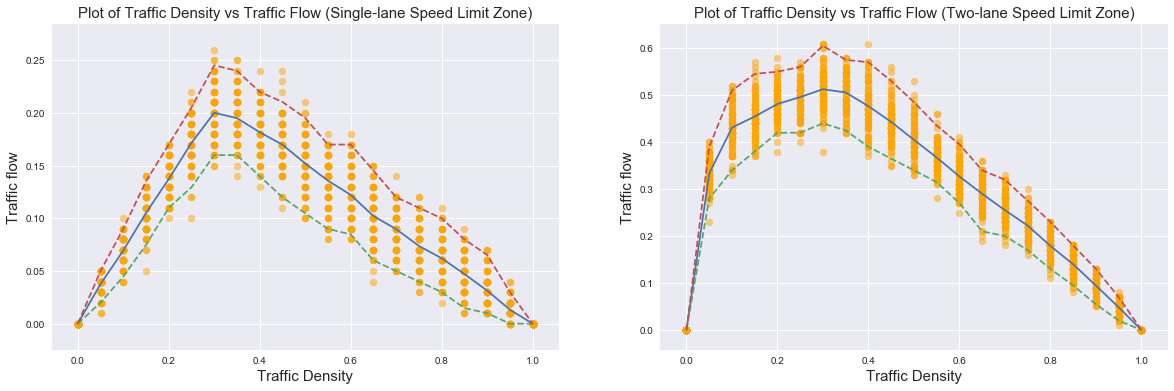

,Traffic Density,Single-lane Mean flow,Two-lane Mean flow
0,0.0,0.0000,0.0000
1,0.1,0.0694,0.4309
2,0.2,0.1373,0.4812
3,0.3,0.2002,0.5127
4,0.4,0.1817,0.4766
5,0.5,0.1521,0.4049
6,0.6,0.1223,0.3269
7,0.7,0.0897,0.2551
8,0.8,0.0621,0.1790
9,0.9,0.0314,0.0946


In [953]:
#plot stats
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plot_flow(speed_lim_1_traffic_flows, speed_lim_1_mean, speed_lim_1_CI, 'Single-lane Speed Limit Zone')
plt.subplot(1,2,2)
plot_flow(speed_lim_2_traffic_flows, speed_lim_2_mean, speed_lim_2_CI, 'Two-lane Speed Limit Zone')
plt.show()

#create dataframe
speed_lim_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': speed_lim_1_mean[::2],
    'Two-lane Mean flow': speed_lim_2_mean[::2]
    })

speed_lim_df


In [954]:
#traffic lights

tl_1_traffic_flows, tl_1_mean, tl_1_CI = sim_diff_density(TrafficSimExtended,
                                                        traffic_light = (0,50,10,10),
                                                        obstacle = (-1,30),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]))
tl_2_traffic_flows, tl_2_mean, tl_2_CI = sim_diff_density(TrafficSimExtendedTwoLane,
                                                        traffic_light = (0,50,10,10),
                                                        obstacle = (-1,30),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]),
                                                        lane_merge = (-1,np.arange(-1,-100)))



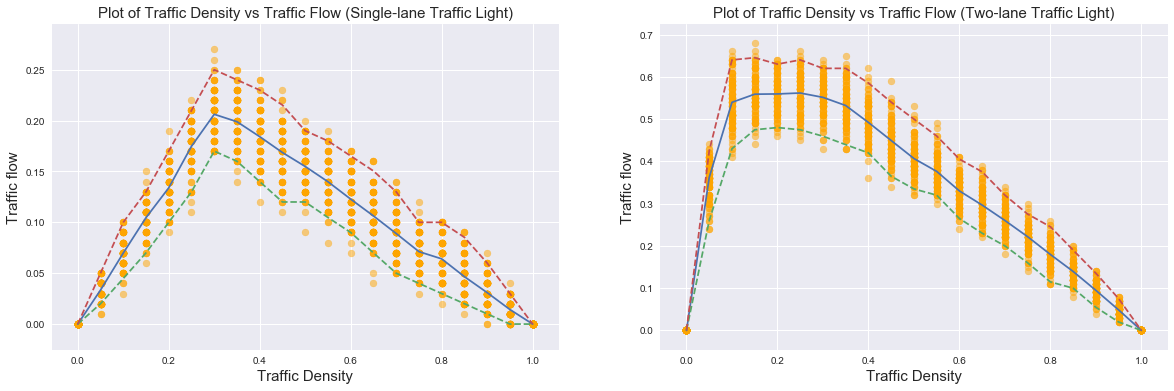

,Traffic Density,Single-lane Mean flow,Two-lane Mean flow
0,0.0,0.0000,0.0000
1,0.1,0.0698,0.5397
2,0.2,0.1339,0.5595
3,0.3,0.2062,0.5514
4,0.4,0.1842,0.4920
5,0.5,0.1549,0.4067
6,0.6,0.1228,0.3300
7,0.7,0.0890,0.2601
8,0.8,0.0641,0.1797
9,0.9,0.0309,0.0948


In [956]:
#plot stats
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plot_flow(tl_1_traffic_flows, tl_1_mean, tl_1_CI, 'Single-lane Traffic Light')
plt.subplot(1,2,2)
plot_flow(tl_2_traffic_flows, tl_2_mean, tl_2_CI, 'Two-lane Traffic Light')
plt.show()

#create dataframe
tl_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': tl_1_mean[::2],
    'Two-lane Mean flow': tl_2_mean[::2]
    })

tl_df

In [957]:
#obstacle & lane-merge

obs_1_traffic_flows, obs_1_mean, obs_1_CI = sim_diff_density(TrafficSimExtended,
                                                        traffic_light = (-1,-1,10,10),
                                                        obstacle = (0,70),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]))
obs_2_traffic_flows, obs_2_mean, obs_2_CI = sim_diff_density(TrafficSimExtendedTwoLane,
                                                        traffic_light = (-1,-1,10,10),
                                                        obstacle = (0,70),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]),
                                                        lane_merge = (0,np.arange(70,100)))



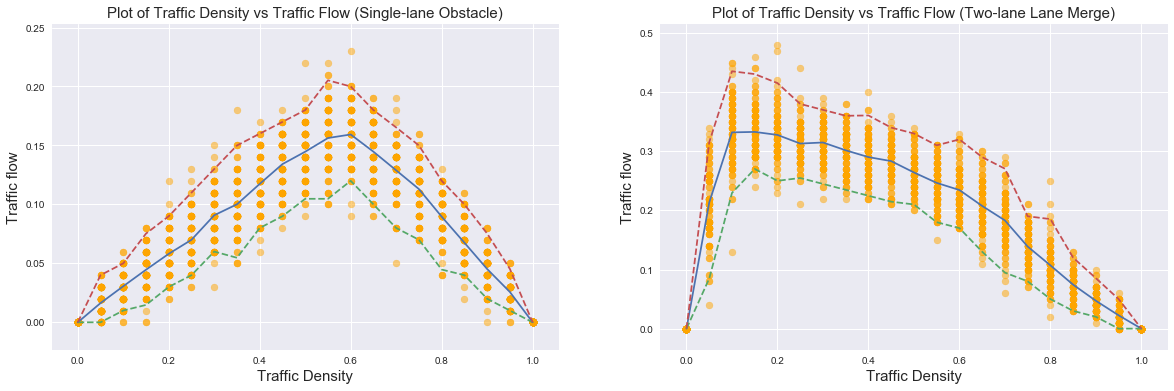

,Traffic Density,Single-lane Mean flow,Two-lane Mean flow
0,0.0,0.0000,0.0000
1,0.1,0.0306,0.3319
2,0.2,0.0581,0.3276
3,0.3,0.0908,0.3148
4,0.4,0.1174,0.2901
5,0.5,0.1447,0.2641
6,0.6,0.1593,0.2344
7,0.7,0.1289,0.1830
8,0.8,0.0896,0.1070
9,0.9,0.0452,0.0471


In [958]:
#plot stats
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plot_flow(obs_1_traffic_flows, obs_1_mean, obs_1_CI, 'Single-lane Obstacle')
plt.subplot(1,2,2)
plot_flow(obs_2_traffic_flows, obs_2_mean, obs_2_CI, 'Two-lane Lane Merge')
plt.show()

#create dataframe
obs_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': obs_1_mean[::2],
    'Two-lane Mean flow': obs_2_mean[::2]
    })

obs_df

<h2>How the Extended Models Work</h2>

By introducing speed limit zones, traffic lights, obstacles, and lane-merges, the extended models add some much needed complexity (but arguably still not enough) to the simple models. The various features work as follows:

<b>Speed Limit Zones</b>

The speed limit zone feature is implemented by setting a max speed limit in designated ranges throughout the numpy array. A new variable, curr_max_speed, is created and is set to the speed limit for each part of the road. The curr_max_speed variable substitutes the self.max_speed parameter used in the simple models.

To symbolize a part of the road without a speed limit, I either set the speed limit == max_speed of the cars, or just remove that range from the speed_lim_zone parameter altogether (though the former step is easier to implement).

<b>Traffic Lights</b>

The traffic light is similar to the speed limit zone in that it enforces a speed limit within a limited range that can be roughly represented as ( traffic_light_index - curr_max_speed, traffic_light_index ). This was not how I wrote it in the code, but my code does carry out its meaning, i.e. when the traffic light is on, any car whose index is before the traffic light index and whose current velocity would cause it to surpass the traffic light has to decelerate so that it comes to a stop at the traffic light index. This means that if a car is at the traffic_light_index, the speed limit is 0; if a car is one cell away from the traffic_light_index, the speed limit is 1; if a car is two cells away from the traffic_light_index, the speed limit is 2, etc. This is assuming that there are no other cars in front of the car.

The traffic light on (stop) and off (go) time-intervals are created by dividing the global_time parameter (i.e. the number of update steps carried out on the simulation) into regular intervals according to the designated on and off time as stipulated by the user.

<b>Obstacles</b>

The obstacle was represented as a permanently stationary car, i.e. an index permanently set to 0.

<b>Lane Merges</b>

The lane-merge was represented as a sequence of permanently stationary cars, i.e. a range of indices permanently set to 0.

<b>New Lane-Switch Procedure</b>

The most challenging part of implementing the extended models was figuring out the new lane-switch procedure for the two-lane model. In the simple model, the lane-switch could occur as long as it was safe and there was available distance to accelerate. In the extended model, even if those two conditions are met, the current car might still be better off not switching lanes since it could switch into a lane with a slower speed-zone limit or switch into a lane with an ongoing traffic light. To solve this issue, I made sure to run the traffic light check and the speed zone check on the other lane as well as the current lane, then compared the max speed limits of both lanes so that the optimal lane could be chosen.

<h2>Summary of Results for Extended Models</h2>

From the results, it appears that the two-lane model outperforms the single-lane model when implementing speed limit zones, traffic lights, and obstacles/lane-merges, as predicted. While this is an intuitive prediction, it is still useful to run these simulations to prove the intuition. A key takeaway from this is that in the simple version of the models (sans extensions), the two-lane model does not appear to outperform the single-lane model that greatly. However, once additional features are implemented that make the model more closely resemble roads and traffic in real-life, the two-lane model greatly outperforms the single-lane model.

<h2>Part 5: Future Work</h2>

How to further extend model to be more realistic

Potential HCs: 
- estimation (estimating the traffic flow on 3-lane or higher models)
- descriptivestats
- confidenceinterval (explaning the confidence intervals included in the traffic flow plot)
- systemdynamics (identify potential attractor states - what are the typical "stable states" of the models?)
- studyreplication (replicating nagel-schreckenberg and rickert et al.'s models + extending on them)